In [12]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [41]:
include("../src/make_fishs_products.jl");

In [14]:
fishdatadir = "/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/"
datafileS = joinpath(fishdatadir, "Fish_spa_abs.csv");
outputfileS = joinpath(outputdirFish, replace(basename(datafileS), ".csv" => ".nc"))

"../output/fish/Fish_spa_abs.nc"

## Data reading
We use the function `read_fish` define in the module `make_benthos_products.jl`.

In [15]:
@time obslonS, obslatS, obsyearS, g1S, g2S, g3S, g4S = read_fish(datafileS);
@info extrema(obslonS)
@info extrema(obslatS)

  0.684110 seconds (5.56 M allocations: 141.481 MiB, 3.60% gc time)


┌ Info: Working on a spatial data file
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:34
┌ Info: Number of data points: 37739
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:46
┌ Info: (-15.9157, 22.2)
└ @ Main In[15]:2
┌ Info: (36.0013, 61.8833)
└ @ Main In[15]:3


### Mask and metrics

In [16]:
xi,yi = DIVAnd.ndgrid(gridlonFish, gridlatFish);
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

#### Extract the mask from the bathymetry

In [17]:
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonFish, gridlatFish);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonFish, gridlatFish,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

┌ Info: (391, 261)
└ @ Main In[17]:11


### Plot the data values

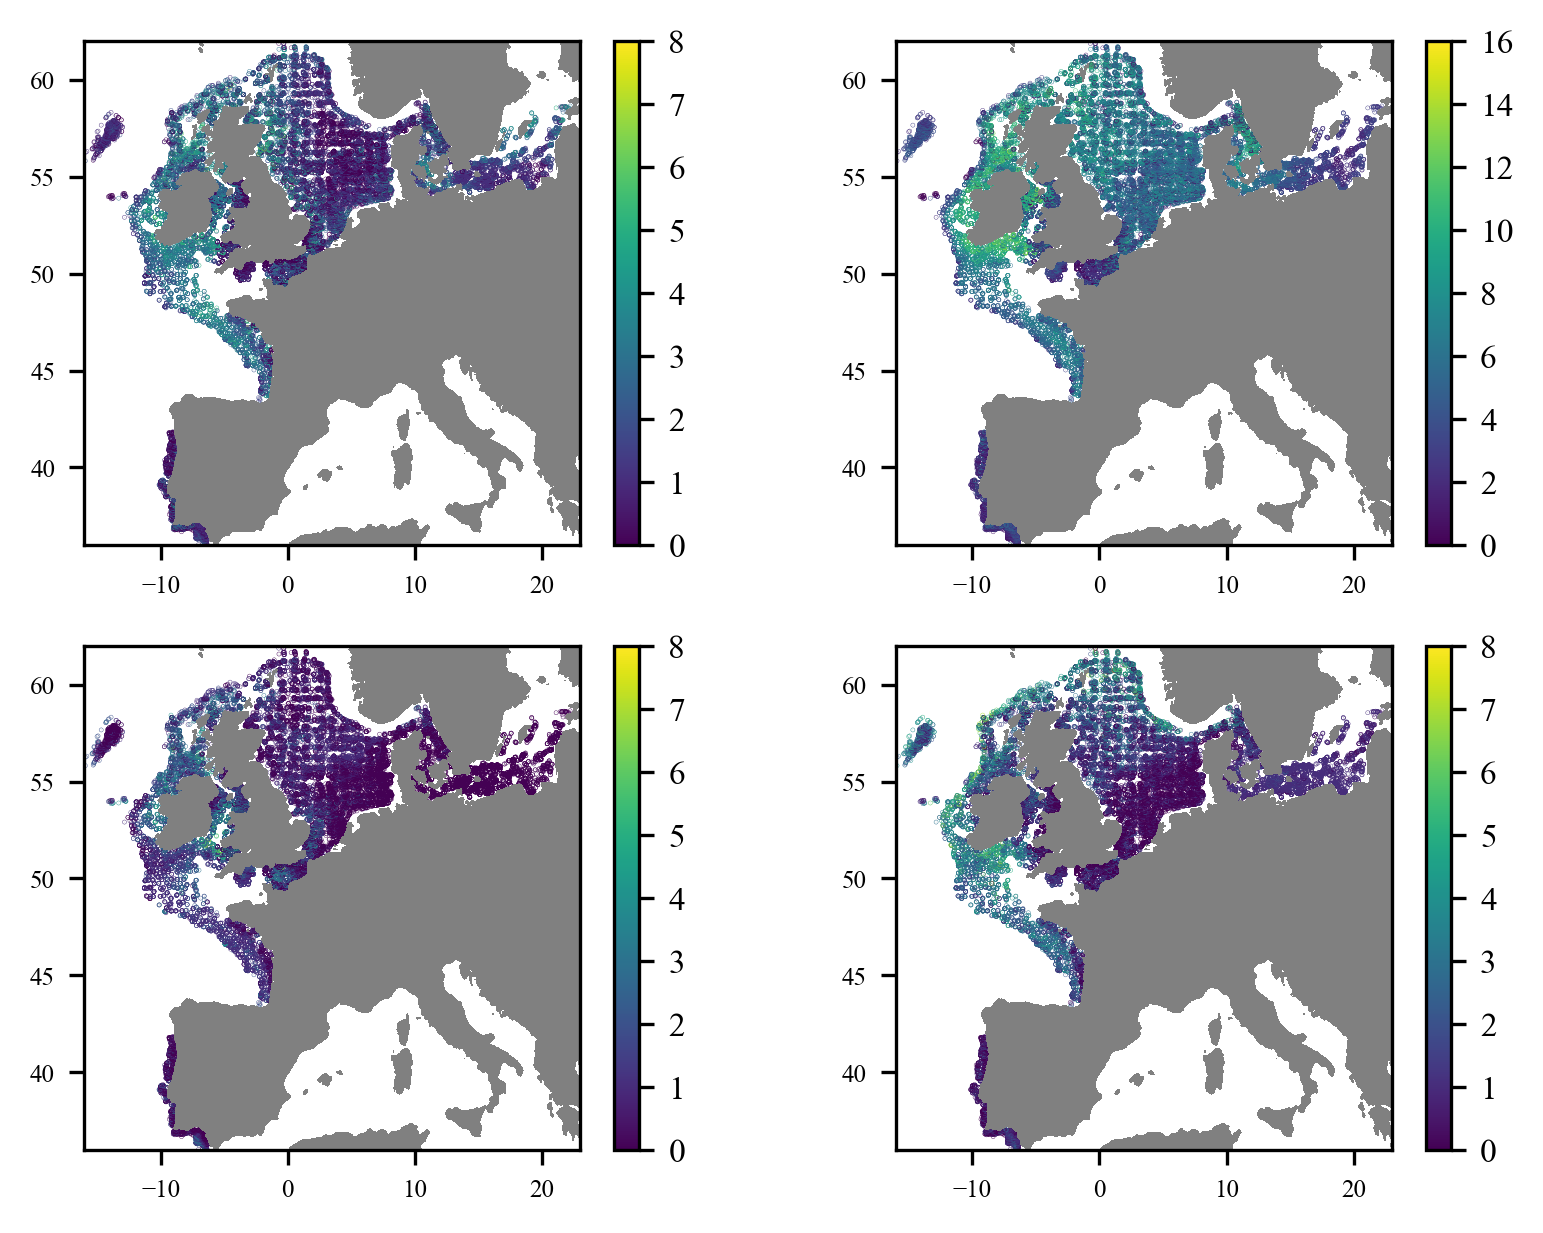

In [18]:
plot_fish_data(obslonS, obslatS, g1S, g2S, g3S, g4S)
PyPlot.savefig(joinpath(figdirFish, "fish_spatial_data.png"), 
        dpi=300, bbox_inches="tight")

## Spatial analysis
All the data are considered simultaneously, i.e. the year of measurement is not taken into account.

### Parameter determination
#### Correlation length

In [12]:
"""
distbin = 0:.5:7.5;
mincount = 100;
var0,lenHori1,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g1log .- mean(g1log),distbin,mincount);
var0,lenHori2,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g2log .- mean(g2log),distbin,mincount);
var0,lenHori3,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g3log .- mean(g3log),distbin,mincount);
var0,lenHori4,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g4log .- mean(g4log),distbin,mincount);
@show lenHori1, lenHori2, lenHori3, lenHori4
"""

"distbin = 0:.5:7.5;\nmincount = 100;\nvar0,lenHori1,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g1log .- mean(g1log),distbin,mincount);\nvar0,lenHori2,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g2log .- mean(g2log),distbin,mincount);\nvar0,lenHori3,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g3log .- mean(g3log),distbin,mincount);\nvar0,lenHori4,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g4log .- mean(g4log),distbin,mincount);\n@show lenHori1, lenHori2, lenHori3, lenHori4\n"

#### Data weights
The weight is decreased for very close points.

In [13]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslonS,obslatS),(0.03,0.03))
@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (34.37624664581307, 7.5999287214601505)


(34.37624664581307, 7.5999287214601505)

#### Signal-to-noise ratio
We use the cross-validation tool for each of the 4 variables.

In [12]:
"""
epsilon2 = 0.02;
bestfactorl1,bestfactore1, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = 
DIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),g1log .- mean(g1log),lenHori1,epsilon2*rdiag,2,3);
@show bestfactorl1, bestfactore1
"""

"epsilon2 = 0.02;\nbestfactorl1,bestfactore1, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = \nDIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),g1log .- mean(g1log),lenHori1,epsilon2*rdiag,2,3);\n@show bestfactorl1, bestfactore1\n"

In [13]:
#epsilon2new = epsilon2 * bestfactore1

In [14]:
#lenHori1new = lenHori1 * bestfactorl1

The optimisation tools provide too small values for L and ε², leading to a noisy, unrealistic interpolated field.     
It is then prefered to fix those parameters.

In [21]:
len = 4.0
epsilon2 = 10.;

## Perform interpolation
### Analysis

In [23]:
🐟1, 🐟2, 🐟3, 🐟4 = make_fish_analysis(obslonS, obslatS, g1S, g2S, g3S, g4S);

  0.868746 seconds (1.72 M allocations: 998.471 MiB, 33.45% gc time)
  0.948010 seconds (1.72 M allocations: 998.471 MiB, 30.63% gc time)
  0.917467 seconds (1.72 M allocations: 998.471 MiB, 41.57% gc time)
  0.942792 seconds (1.72 M allocations: 998.471 MiB, 32.59% gc time)


### Create plot

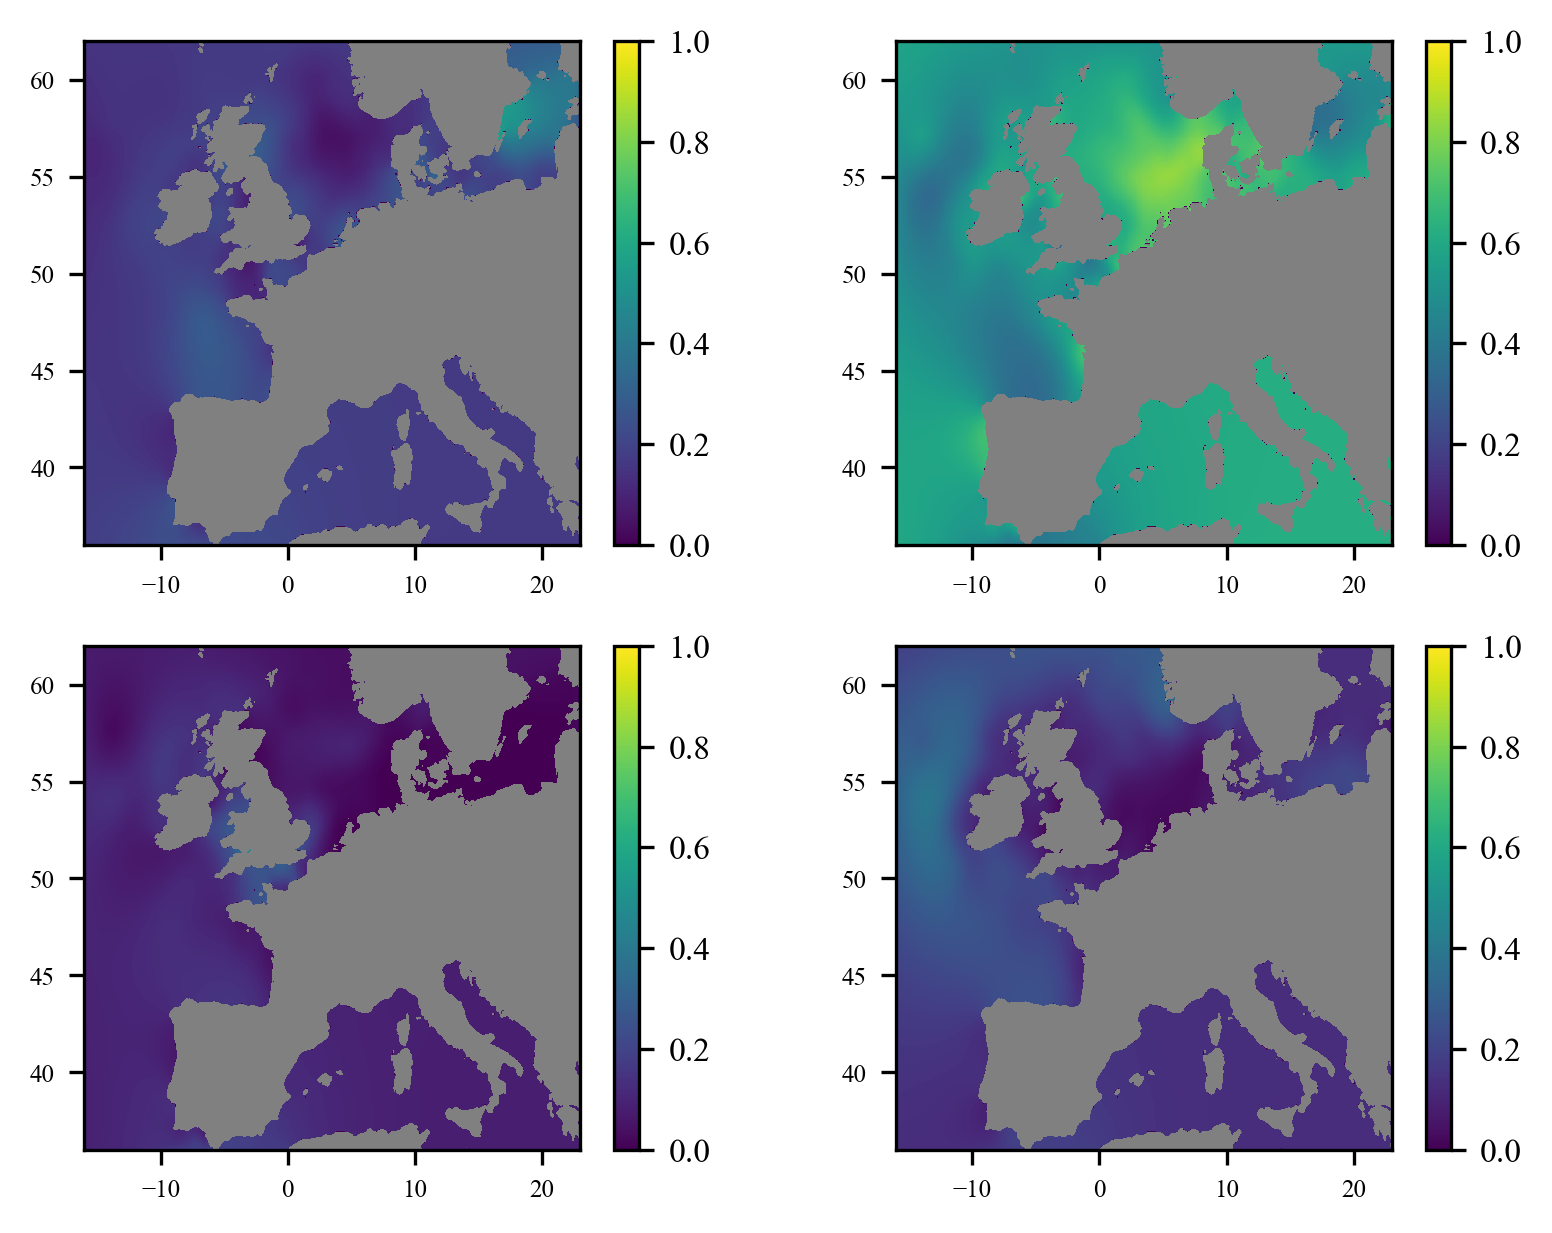

In [28]:
plot_fish_results(gridlonFish, gridlatFish, 🐟1, 🐟2, 🐟3, 🐟4, bx, by, b)
PyPlot.savefig(joinpath(figdirFish, "fish_spatial_field.png"), 
    dpi=300, bbox_inches="tight")

### Error field
Using the CPME method.

In [25]:
🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err = compute_fish_error(obslonS, obslatS, g1S, g2S, g3S, g4S);

### Create plot

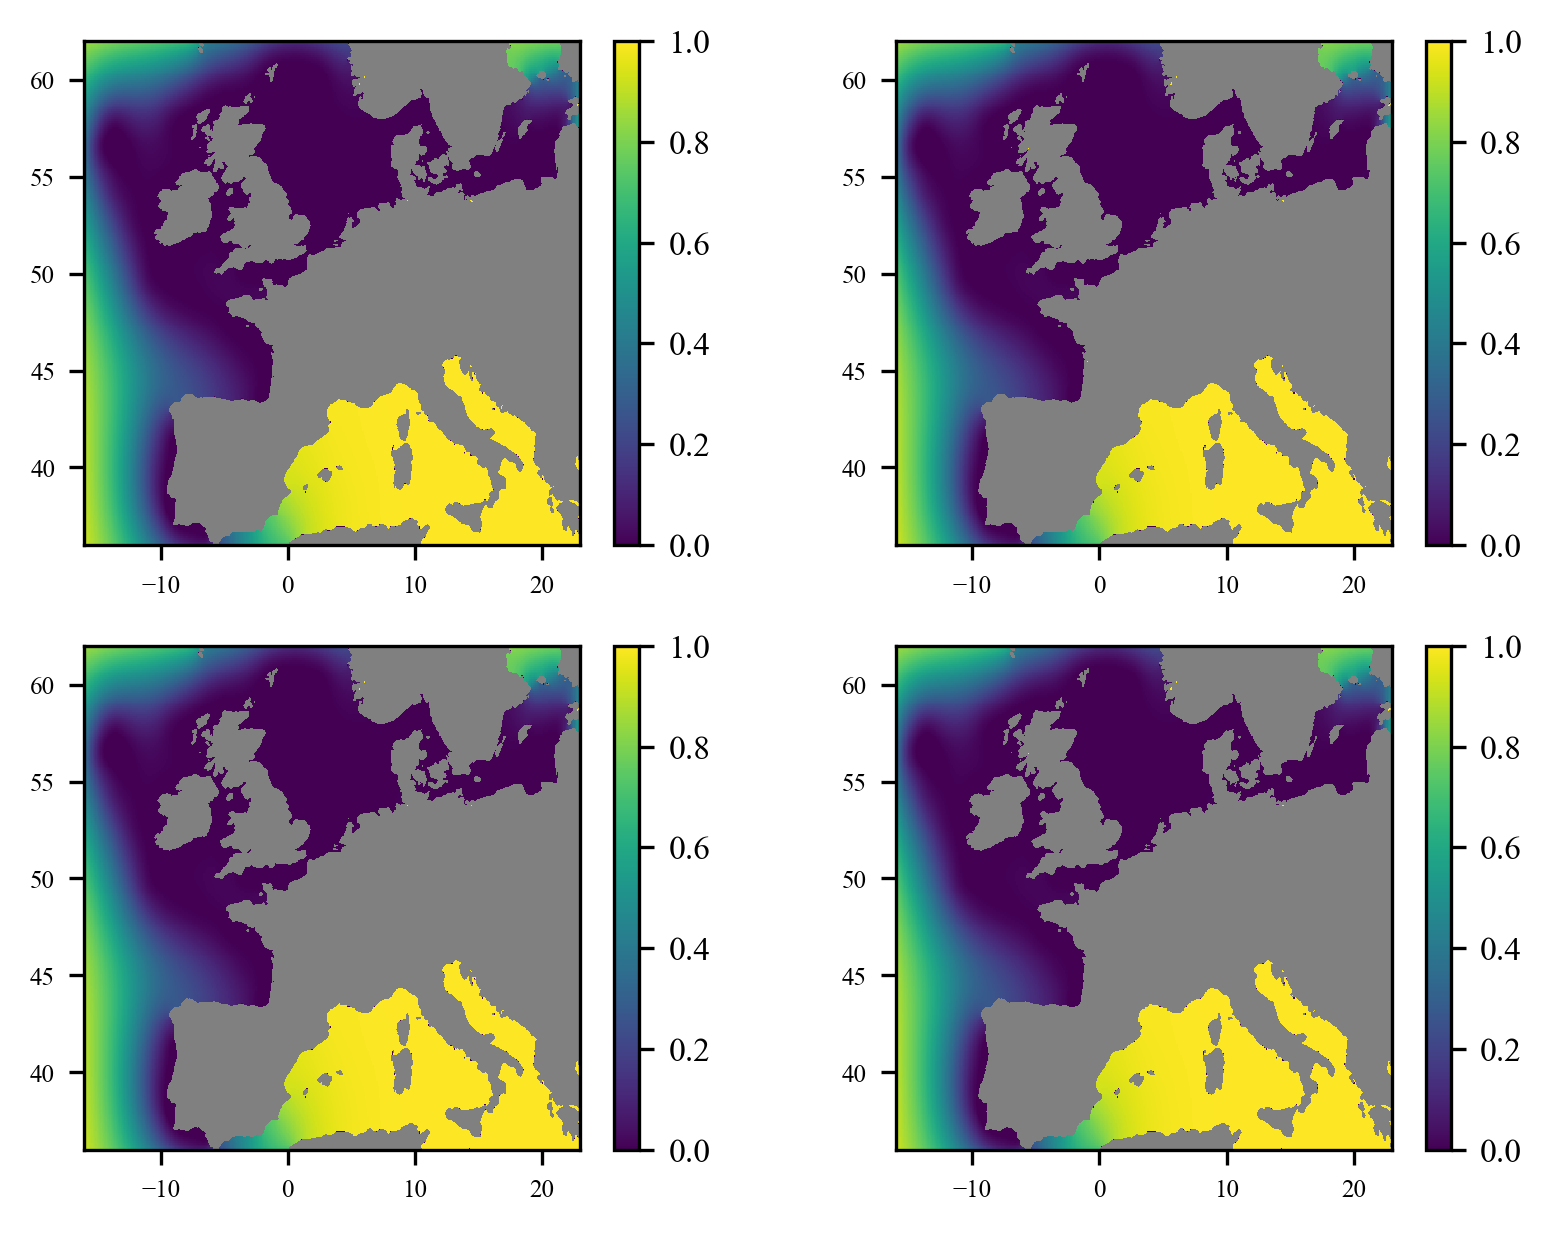

In [29]:
plot_fish_results(gridlonFish, gridlatFish, 🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err, bx, by, b)
PyPlot.savefig(joinpath(figdirFish, "fish_spatial_error.png"), 
    dpi=300, bbox_inches="tight")

### Write the netCDF with all the fields

In [31]:
@info "Writing netCDF file $(outputfileS)"
write_fish_nc(outputfileS, gridlonFish, gridlatFish, 🐟1,🐟2,🐟3,🐟4,
    🐟1_err,🐟2_err,🐟3_err,🐟4_err);

┌ Info: Writing netCDF file ../output/fish/Fish_spa_abs.nc
└ @ Main In[31]:1


## Temporal analysis
We work with 3-year periods ranging from 2000 to 2018.

In [33]:
datafileT = joinpath(fishdatadir, "Fish_temp_abs.csv");
outputfileT = joinpath(outputdirFish, replace(basename(datafileT), ".csv" => ".nc"))

"../output/fish/Fish_temp_abs.nc"

### Read data

In [34]:
@time obslonT, obslatT, obsyearT, g1T, g2T, g3T, g4T = read_fish(datafileT);

┌ Info: Working on a temporal data file
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:30
┌ Info: Number of data points: 37595
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:46


  1.339051 seconds (8.76 M allocations: 228.785 MiB, 5.31% gc time)


In [35]:
# Loop on the years
yearmin = 2000;
yearmax = 2018;
# Allocate arrays

nyears = length(yearmin:yearmax);
nlon = length(gridlonFish);
nlat = length(gridlatFish);

# Allocate arrays
🐟1_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟2_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟3_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟4_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));

🐟1_err_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟2_err_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟3_err_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));
🐟4_err_time = Array{Float64, 3}(undef, (nlon, nlat, nyears));

for (iy, yyyy) in enumerate(yearmin:yearmax)
    goodyears = (obsyearT .<= yyyy + 1) .& (obsyearT .>= yyyy - 1)
    @info "Number of observations for the year range $(yyyy-1)-$(yyyy+1): $(sum(goodyears))"
    # Select good data
    
    🐟1, 🐟2, 🐟3, 🐟4 = make_fish_analysis(obslonT, obslatT, g1T, g2T, g3T, g4T);
    
    🐟1_time[:,:,iy] = 🐟1;
    🐟2_time[:,:,iy] = 🐟2;
    🐟3_time[:,:,iy] = 🐟3;
    🐟4_time[:,:,iy] = 🐟4;
    
    🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err = compute_fish_error(obslonT, obslatT, g1T, g2T, g3T, g4T);
    
    🐟1_err_time[:,:,iy] = 🐟1_err;
    🐟2_err_time[:,:,iy] = 🐟2_err;
    🐟3_err_time[:,:,iy] = 🐟3_err;
    🐟4_err_time[:,:,iy] = 🐟4_err;
    
end

┌ Info: Number of observations for the year range 1999-2001: 3125
└ @ Main In[35]:23


  0.927135 seconds (1.72 M allocations: 998.308 MiB, 32.66% gc time)
  0.873854 seconds (1.72 M allocations: 998.308 MiB, 33.77% gc time)
  0.841750 seconds (1.72 M allocations: 998.308 MiB, 33.77% gc time)
  0.871224 seconds (1.72 M allocations: 998.308 MiB, 32.61% gc time)


┌ Info: Number of observations for the year range 2000-2002: 4830
└ @ Main In[35]:23


  0.834085 seconds (1.72 M allocations: 998.308 MiB, 33.63% gc time)
  0.836564 seconds (1.72 M allocations: 998.308 MiB, 33.84% gc time)
  0.839378 seconds (1.72 M allocations: 998.308 MiB, 34.10% gc time)
  0.835647 seconds (1.72 M allocations: 998.308 MiB, 34.15% gc time)


┌ Info: Number of observations for the year range 2001-2003: 5201
└ @ Main In[35]:23


  0.854135 seconds (1.72 M allocations: 998.308 MiB, 33.19% gc time)
  0.847212 seconds (1.72 M allocations: 998.308 MiB, 33.56% gc time)
  0.845031 seconds (1.72 M allocations: 998.308 MiB, 33.90% gc time)
  0.856541 seconds (1.72 M allocations: 998.308 MiB, 33.38% gc time)


┌ Info: Number of observations for the year range 2002-2004: 5415
└ @ Main In[35]:23


  0.855606 seconds (1.72 M allocations: 998.308 MiB, 33.29% gc time)
  0.844349 seconds (1.72 M allocations: 998.308 MiB, 33.66% gc time)
  0.868106 seconds (1.72 M allocations: 998.308 MiB, 33.56% gc time)
  0.846665 seconds (1.72 M allocations: 998.308 MiB, 33.80% gc time)


┌ Info: Number of observations for the year range 2003-2005: 5555
└ @ Main In[35]:23


  0.835194 seconds (1.72 M allocations: 998.308 MiB, 33.90% gc time)
  0.859918 seconds (1.72 M allocations: 998.308 MiB, 33.35% gc time)
  0.844022 seconds (1.72 M allocations: 998.308 MiB, 34.26% gc time)
  0.840050 seconds (1.72 M allocations: 998.308 MiB, 33.96% gc time)


┌ Info: Number of observations for the year range 2004-2006: 5547
└ @ Main In[35]:23


  0.840181 seconds (1.72 M allocations: 998.308 MiB, 33.96% gc time)
  0.849052 seconds (1.72 M allocations: 998.308 MiB, 33.53% gc time)
  0.843800 seconds (1.72 M allocations: 998.308 MiB, 33.86% gc time)
  0.835397 seconds (1.72 M allocations: 998.308 MiB, 34.10% gc time)


┌ Info: Number of observations for the year range 2005-2007: 5602
└ @ Main In[35]:23


  0.864746 seconds (1.72 M allocations: 998.308 MiB, 32.94% gc time)
  0.845461 seconds (1.72 M allocations: 998.308 MiB, 33.65% gc time)
  0.857855 seconds (1.72 M allocations: 998.308 MiB, 33.63% gc time)
  0.847424 seconds (1.72 M allocations: 998.308 MiB, 33.69% gc time)


┌ Info: Number of observations for the year range 2006-2008: 5719
└ @ Main In[35]:23


  0.834414 seconds (1.72 M allocations: 998.308 MiB, 34.03% gc time)
  0.840009 seconds (1.72 M allocations: 998.308 MiB, 33.87% gc time)
  0.839580 seconds (1.72 M allocations: 998.308 MiB, 34.16% gc time)
  0.837140 seconds (1.72 M allocations: 998.308 MiB, 34.14% gc time)


┌ Info: Number of observations for the year range 2007-2009: 5921
└ @ Main In[35]:23


  0.861438 seconds (1.72 M allocations: 998.308 MiB, 34.11% gc time)
  0.840145 seconds (1.72 M allocations: 998.308 MiB, 33.71% gc time)
  0.846605 seconds (1.72 M allocations: 998.308 MiB, 33.85% gc time)
  0.874435 seconds (1.72 M allocations: 998.308 MiB, 33.28% gc time)


┌ Info: Number of observations for the year range 2008-2010: 5965
└ @ Main In[35]:23


  0.835464 seconds (1.72 M allocations: 998.308 MiB, 33.78% gc time)
  0.835192 seconds (1.72 M allocations: 998.308 MiB, 33.80% gc time)
  0.850945 seconds (1.72 M allocations: 998.308 MiB, 33.30% gc time)
  0.873285 seconds (1.72 M allocations: 998.308 MiB, 32.76% gc time)


┌ Info: Number of observations for the year range 2009-2011: 6148
└ @ Main In[35]:23


  0.837410 seconds (1.72 M allocations: 998.308 MiB, 33.81% gc time)
  0.840439 seconds (1.72 M allocations: 998.308 MiB, 34.17% gc time)
  0.852266 seconds (1.72 M allocations: 998.308 MiB, 35.12% gc time)
  0.839728 seconds (1.72 M allocations: 998.308 MiB, 34.15% gc time)


┌ Info: Number of observations for the year range 2010-2012: 6676
└ @ Main In[35]:23


  0.833353 seconds (1.72 M allocations: 998.308 MiB, 33.87% gc time)
  0.845979 seconds (1.72 M allocations: 998.308 MiB, 34.12% gc time)
  0.840429 seconds (1.72 M allocations: 998.308 MiB, 34.22% gc time)
  0.841459 seconds (1.72 M allocations: 998.308 MiB, 34.27% gc time)


┌ Info: Number of observations for the year range 2011-2013: 7311
└ @ Main In[35]:23


  0.827728 seconds (1.72 M allocations: 998.308 MiB, 33.99% gc time)
  0.860580 seconds (1.72 M allocations: 998.308 MiB, 33.81% gc time)
  0.845806 seconds (1.72 M allocations: 998.308 MiB, 34.20% gc time)
  0.836685 seconds (1.72 M allocations: 998.308 MiB, 34.42% gc time)


┌ Info: Number of observations for the year range 2012-2014: 7660
└ @ Main In[35]:23


  0.833438 seconds (1.72 M allocations: 998.308 MiB, 33.89% gc time)
  0.858928 seconds (1.72 M allocations: 998.308 MiB, 33.64% gc time)
  0.859498 seconds (1.72 M allocations: 998.308 MiB, 33.34% gc time)
  0.839223 seconds (1.72 M allocations: 998.308 MiB, 34.30% gc time)


┌ Info: Number of observations for the year range 2013-2015: 7682
└ @ Main In[35]:23


  0.854165 seconds (1.72 M allocations: 998.308 MiB, 33.18% gc time)
  0.838658 seconds (1.72 M allocations: 998.308 MiB, 34.30% gc time)
  0.852653 seconds (1.72 M allocations: 998.308 MiB, 34.32% gc time)
  0.835454 seconds (1.72 M allocations: 998.308 MiB, 34.29% gc time)


┌ Info: Number of observations for the year range 2014-2016: 7766
└ @ Main In[35]:23


  0.833470 seconds (1.72 M allocations: 998.308 MiB, 33.77% gc time)
  0.859069 seconds (1.72 M allocations: 998.308 MiB, 33.57% gc time)
  0.835580 seconds (1.72 M allocations: 998.308 MiB, 34.29% gc time)
  0.834866 seconds (1.72 M allocations: 998.308 MiB, 34.35% gc time)


┌ Info: Number of observations for the year range 2015-2017: 7683
└ @ Main In[35]:23


  0.856360 seconds (1.72 M allocations: 998.308 MiB, 33.08% gc time)
  0.845894 seconds (1.72 M allocations: 998.308 MiB, 33.88% gc time)
  0.837838 seconds (1.72 M allocations: 998.308 MiB, 34.52% gc time)
  0.855086 seconds (1.72 M allocations: 998.308 MiB, 33.93% gc time)


┌ Info: Number of observations for the year range 2016-2018: 5095
└ @ Main In[35]:23


  0.830751 seconds (1.72 M allocations: 998.308 MiB, 33.88% gc time)
  0.857210 seconds (1.72 M allocations: 998.308 MiB, 33.44% gc time)
  0.846190 seconds (1.72 M allocations: 998.308 MiB, 33.99% gc time)
  0.858698 seconds (1.72 M allocations: 998.308 MiB, 33.60% gc time)


┌ Info: Number of observations for the year range 2017-2019: 2411
└ @ Main In[35]:23


  0.831048 seconds (1.72 M allocations: 998.308 MiB, 34.01% gc time)
  0.851013 seconds (1.72 M allocations: 998.308 MiB, 34.61% gc time)
  0.840740 seconds (1.72 M allocations: 998.308 MiB, 34.13% gc time)
  0.836326 seconds (1.72 M allocations: 998.308 MiB, 34.27% gc time)


In [42]:
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟1_time, bx, by, b);
PyPlot.savefig(joinpath(figdirFish, "fish_time01.png"), dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟2_time, bx, by, b);
PyPlot.savefig(joinpath(figdirFish, "fish_time02.png"), dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟3_time, bx, by, b);
PyPlot.savefig(joinpath(figdirFish, "fish_time03.png"), dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟4_time, bx, by, b);
PyPlot.savefig(joinpath(figdirFish, "fish_time04.png"), dpi=300, bbox_inches="tight")
PyPlot.close_figs()

### Write the netCDF 
One file with all the variables

In [43]:
@info "Writing netCDF file $(outputfileT)"
write_fish_time_nc(outputfileT, gridlonFish, gridlatFish, collect(yearmin:yearmax),
    🐟1_time, 🐟2_time, 🐟3_time, 🐟4_time,
    🐟1_err_time, 🐟2_err_time, 🐟3_err_time, 🐟4_err_time);

┌ Info: Writing netCDF file ../output/fish/Fish_temp_abs.nc
└ @ Main In[43]:1
